This examples covers the callable methods of the Python AWIPS DAF when working with gridded data.  We start with a connection to an EDEX server, then query data types, then grid names, parameters, levels, and other information. Finally the gridded data is plotted for its domain using Matplotlib and Cartopy.

### DataAccessLayer.changeEDEXHost()

After DataAccessLayer is imported from the package `awips.dataaccess`, the first step is to define the EDEX data server hostname (`edex-cloud.unidata.ucar.edu` for these examples)



In [37]:
from awips.dataaccess import DataAccessLayer
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

### DataAccessLayer.getSupportedDatatypes()

getSupportedDatatypes() returns a list of available data types offered by the EDEX server defined above. 

In [38]:
dataTypes = DataAccessLayer.getSupportedDatatypes()
list(dataTypes)

['acars',
 'airep',
 'binlightning',
 'bufrmosavn',
 'bufrmoseta',
 'bufrmosgfs',
 'bufrmoshpc',
 'bufrmoslamp',
 'bufrmosmrf',
 'bufrmosngm',
 'bufrua',
 'climate',
 'common_obs_spatial',
 'ffmp',
 'gfe',
 'grid',
 'hydro',
 'ldadmesonet',
 'maps',
 'modelsounding',
 'obs',
 'pirep',
 'practicewarning',
 'profiler',
 'radar',
 'radar_spatial',
 'satellite',
 'sfcobs',
 'warning']

### DataAccessLayer.newDataRequest()

Now create a new data request, and set the data type to **grid** and "locationName" to **RAP40** with **setDataType()** and **setLocationNames()**

In [39]:
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")

### DataAccessLayer.getAvailableLocationNames()

With datatype set to "grid", we can query all available grid names with **getAvailableLocationNames()**

In [40]:
available_grids = DataAccessLayer.getAvailableLocationNames(request)
available_grids.sort()
list(available_grids)

['CMC',
 'DGEX',
 'ESTOFS',
 'ETSS',
 'FFG-ALR',
 'FFG-FWR',
 'FFG-KRF',
 'FFG-MSR',
 'FFG-ORN',
 'FFG-PTR',
 'FFG-RHA',
 'FFG-RSA',
 'FFG-STR',
 'FFG-TAR',
 'FFG-TIR',
 'FFG-TUA',
 'FNMOC-FAROP',
 'GFS',
 'GFS20',
 'GFSGuide',
 'GFSLAMP5',
 'GLERL',
 'GribModel:58:0:135',
 'GribModel:58:0:18',
 'GribModel:58:0:78',
 'GribModel:9:151:172',
 'HFR-EAST_6KM',
 'HFR-EAST_PR_6KM',
 'HFR-US_EAST_DELAWARE_1KM',
 'HFR-US_EAST_FLORIDA_2KM',
 'HFR-US_EAST_NORTH_2KM',
 'HFR-US_EAST_SOUTH_2KM',
 'HFR-US_EAST_VIRGINIA_1KM',
 'HFR-US_HAWAII_1KM',
 'HFR-US_HAWAII_2KM',
 'HFR-US_HAWAII_6KM',
 'HFR-US_WEST_500M',
 'HFR-US_WEST_CENCAL_2KM',
 'HFR-US_WEST_LOSANGELES_1KM',
 'HFR-US_WEST_LOSOSOS_1KM',
 'HFR-US_WEST_NORTH_2KM',
 'HFR-US_WEST_SANFRAN_1KM',
 'HFR-US_WEST_SOCAL_2KM',
 'HFR-US_WEST_WASHINGTON_1KM',
 'HFR-WEST_6KM',
 'HPCGuide',
 'HPCqpf',
 'HPCqpfNDFD',
 'HRRR',
 'LAMP2p5',
 'MOSGuide',
 'MOSGuideExtended',
 'MPE-Local-ALR',
 'MPE-Local-MSR',
 'MPE-Local-ORN',
 'MPE-Local-RHA',
 'MPE-Local-RSA'

### Set grid name with `setLocationNames()`

In [41]:
request.setLocationNames("RAP40")

# List Available Parameters for a Grid

### DataAccessLayer.getAvailableParameters()

After datatype and model name (locationName) are set, you can query all available parameters with **getAvailableParameters()**

In [42]:
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
list(availableParms)

['AV',
 'BLI',
 'CAPE',
 'CFRZR',
 'CICEP',
 'CIn',
 'CP',
 'CP10hr',
 'CP11hr',
 'CP12hr',
 'CP13hr',
 'CP14hr',
 'CP15hr',
 'CP16hr',
 'CP17hr',
 'CP18hr',
 'CP1hr',
 'CP2hr',
 'CP3hr',
 'CP4hr',
 'CP5hr',
 'CP6hr',
 'CP9hr',
 'CRAIN',
 'CSNOW',
 'DpD',
 'DpT',
 'EPT',
 'GH',
 'HCDC',
 'HINDEX',
 'HPBL',
 'Heli',
 'LCDC',
 'LTNG',
 'LgSP',
 'LgSP10hr',
 'LgSP11hr',
 'LgSP12hr',
 'LgSP13hr',
 'LgSP14hr',
 'LgSP15hr',
 'LgSP16hr',
 'LgSP17hr',
 'LgSP18hr',
 'LgSP1hr',
 'LgSP2hr',
 'LgSP3hr',
 'LgSP4hr',
 'LgSP5hr',
 'LgSP6hr',
 'LgSP9hr',
 'MCDC',
 'MMSP',
 'MSTAV',
 'P',
 'PLPL',
 'PR',
 'PVV',
 'PW',
 'PoT',
 'REFD',
 'RH',
 'SH',
 'SLI',
 'SnD',
 'T',
 'TOTSN',
 'TOTSN10hr',
 'TOTSN11hr',
 'TOTSN12hr',
 'TOTSN13hr',
 'TOTSN14hr',
 'TOTSN15hr',
 'TOTSN16hr',
 'TOTSN17hr',
 'TOTSN18hr',
 'TOTSN1hr',
 'TOTSN2hr',
 'TOTSN3hr',
 'TOTSN4hr',
 'TOTSN5hr',
 'TOTSN6hr',
 'TOTSN9hr',
 'TP',
 'TP10hr',
 'TP11hr',
 'TP12hr',
 'TP13hr',
 'TP14hr',
 'TP15hr',
 'TP16hr',
 'TP17hr',
 'TP18hr',
 'TP

### setParameters()


set the request parameter

In [43]:
request.setParameters("T")

## List Available Levels for Parameter

Using **DataAccessLayer.getAvailableLevels()**

In [44]:
availableLevels = DataAccessLayer.getAvailableLevels(request)
for level in availableLevels:
    print(level)

875.0MB
575.0MB
650.0MB
675.0MB
0.0TROP
700.0MB
250.0MB
350.0MB
150.0MB
550.0MB
375.0MB
0.0SFC
150.0_180.0BL
120.0_150.0BL
1000.0MB
725.0MB
125.0MB
850.0MB
0.0_30.0BL
325.0MB
225.0MB
400.0MB
450.0MB
600.0MB
2.0FHAG
975.0MB
950.0MB
30.0_60.0BL
475.0MB
825.0MB
425.0MB
525.0MB
200.0MB
775.0MB
60.0_90.0BL
300.0MB
175.0MB
275.0MB
100.0MB
90.0_120.0BL
800.0MB
80.0FHAG
500.0MB
625.0MB
925.0MB
750.0MB
900.0MB


* **0.0SFC** is the Surface level
* **FHAG** stands for Fixed Height Above Ground (in meters)
* **NTAT** stands for Nominal Top of the ATmosphere
* **BL** stands for Boundary Layer, where **0.0_30.0BL** reads as *0-30 mb above ground level*  
* **TROP** is the Tropopause level

### request.setLevels()

For this example we will use Surface Temperature

In [45]:
request.setLevels("0.0SFC")

### DataAccessLayer.getAvailableTimes()

* **getAvailableTimes(request, True)** will return an object of *run times* - formatted as `YYYY-MM-DD HH:MM:SS`
* **getAvailableTimes(request)** will return an object of all times - formatted as `YYYY-MM-DD HH:MM:SS (F:ff)`
* **getForecastCycle(cycle, times)** will return a DataTime array for a single forecast cycle.

In [46]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastCycle(cycles[-1], times)
list(fcstRun)

[<DataTime instance: 2016-10-20 20:00:00 (0) >,
 <DataTime instance: 2016-10-20 20:00:00 (1) >,
 <DataTime instance: 2016-10-20 20:00:00 (2) >,
 <DataTime instance: 2016-10-20 20:00:00 (3) >,
 <DataTime instance: 2016-10-20 20:00:00 (6) >,
 <DataTime instance: 2016-10-20 20:00:00 (9) >,
 <DataTime instance: 2016-10-20 20:00:00 (10) >,
 <DataTime instance: 2016-10-20 20:00:00 (11) >,
 <DataTime instance: 2016-10-20 20:00:00 (12) >,
 <DataTime instance: 2016-10-20 20:00:00 (13) >,
 <DataTime instance: 2016-10-20 20:00:00 (14) >,
 <DataTime instance: 2016-10-20 20:00:00 (15) >,
 <DataTime instance: 2016-10-20 20:00:00 (16) >,
 <DataTime instance: 2016-10-20 20:00:00 (17) >,
 <DataTime instance: 2016-10-20 20:00:00 (18) >]

# Request a Grid

### DataAccessLayer.getGridData()

Now that we have our `request` and DataTime `fcstRun` arrays ready, it's time to request the data array from EDEX.

In [47]:
response = DataAccessLayer.getGridData(request, fcstRun)

In [48]:
for grid in response:
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    print('Time :', str(grid.getDataTime()))

print('Model:', str(grid.getLocationName()))
print('Parm :', str(grid.getParameter()))
print('Unit :', str(grid.getUnit()))
print(data.shape)

('Time :', '2016-10-20 20:00:00 (6)')
('Time :', '2016-10-20 20:00:00 (10)')
('Time :', '2016-10-20 20:00:00 (11)')
('Time :', '2016-10-20 20:00:00 (9)')
('Time :', '2016-10-20 20:00:00 (13)')
('Time :', '2016-10-20 20:00:00 (14)')
('Time :', '2016-10-20 20:00:00 (12)')
('Time :', '2016-10-20 20:00:00 (16)')
('Time :', '2016-10-20 20:00:00 (17)')
('Time :', '2016-10-20 20:00:00 (15)')
('Time :', '2016-10-20 20:00:00 (18)')
('Time :', '2016-10-20 20:00:00 (1)')
('Time :', '2016-10-20 20:00:00 (2)')
('Time :', '2016-10-20 20:00:00 (3)')
('Time :', '2016-10-20 20:00:00 (0)')
('Model:', 'RAP40')
('Parm :', 'T')
('Unit :', 'K')
(151, 113)


# Plot a Grid with Matplotlib and Cartopy



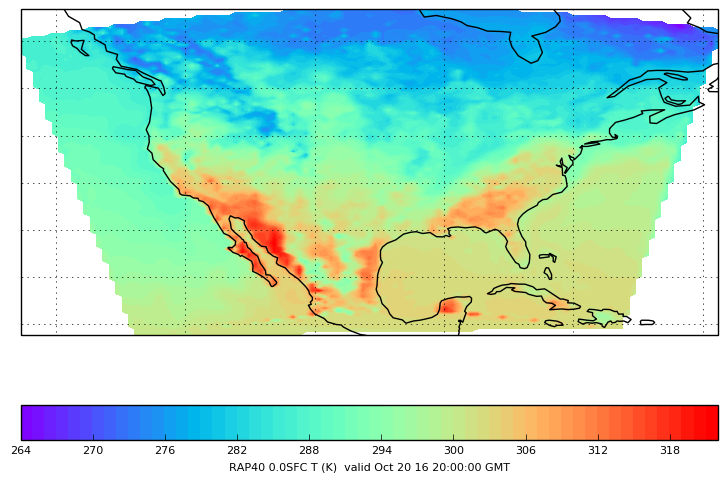

In [49]:
%matplotlib inline
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
ngrid = data.shape[1]
rlons = np.repeat(np.linspace(np.min(lons), np.max(lons), ngrid),
              ngrid).reshape(ngrid, ngrid)
rlats = np.repeat(np.linspace(np.min(lats), np.max(lats), ngrid),
              ngrid).reshape(ngrid, ngrid).T
tli = mtri.LinearTriInterpolator(mtri.Triangulation(lons.flatten(),
               lats.flatten()), data.flatten())
rdata = tli(rlons, rlats)

# Create Map
cmap = plt.get_cmap('rainbow')
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(9, 6), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(rlons, rlats, rdata, 60, cmap=cmap,
                  transform=ccrs.PlateCarree(),
                  vmin=rdata.min(), vmax=rdata.max())

ax.gridlines()
ax.coastlines()
ax.set_aspect('auto', adjustable=None)

cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(str(grid.getLocationName()) +" "+ str(grid.getLevel()) + " "  + str(grid.getParameter()) + " " \
        "(" + str(grid.getUnit()) + ") " + " valid " + str(grid.getDataTime().getRefTime()) )

# Downsampling Large Grids

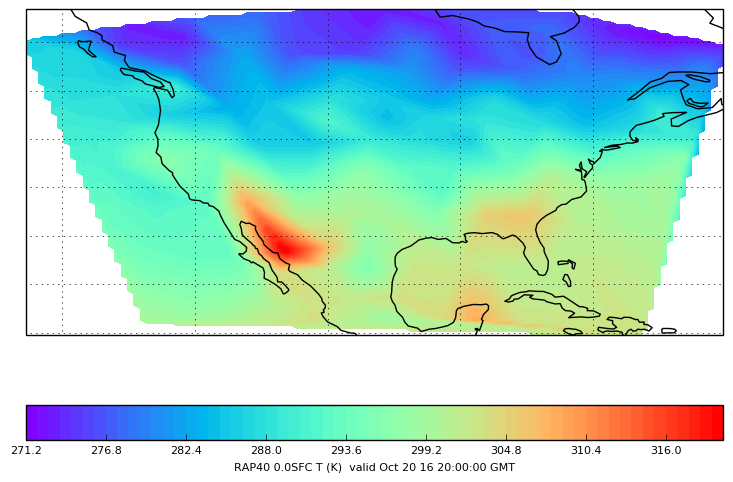

In [53]:
import scipy.ndimage

SCALING = 0.3
data = scipy.ndimage.zoom(data, SCALING, order=0)
lons = scipy.ndimage.zoom(lons, SCALING, order=0)
lats = scipy.ndimage.zoom(lats, SCALING, order=0)
    
rlons = np.repeat(np.linspace(np.min(lons), np.max(lons), ngrid),
              ngrid).reshape(ngrid, ngrid)
rlats = np.repeat(np.linspace(np.min(lats), np.max(lats), ngrid),
              ngrid).reshape(ngrid, ngrid).T
tli = mtri.LinearTriInterpolator(mtri.Triangulation(lons.flatten(),
               lats.flatten()), data.flatten())
rdata = tli(rlons, rlats)

# Create Map
cmap = plt.get_cmap('rainbow')
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(9, 6), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(rlons, rlats, rdata, 60, cmap=cmap,
                  transform=ccrs.PlateCarree(),
                  vmin=rdata.min(), vmax=rdata.max())

ax.gridlines()
ax.coastlines()
ax.set_aspect('auto', adjustable=None)

cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(str(grid.getLocationName()) +" "+ str(grid.getLevel()) + " "  + str(grid.getParameter()) + " " \
        "(" + str(grid.getUnit()) + ") " + " valid " + str(grid.getDataTime().getRefTime()) )